# **Homework on Credit Risk**
## **Building an Application Scoring Model**

### **General Information**
- **Date assigned:** December 2, 2025  
- **Soft deadline:** 23:59 MSK, December 15, 2025  
- **Hard deadline:** 23:59 MSK, December 18, 2025  
- **Submission:** send your work to  
  \texttt{maria.vorobyova.ser@gmail.com}  
  with the subject format:
  \[
  \text{HSE\_CS\_[track]\_FullName}
  \]
  Example:
  \[
  \text{HSE\_CS\_PAD\_IVANOV\_IVAN\_IVANOVICH}
  \]

---

### **Grading and Penalties**
Maximum score: **10 points**

Late penalty:
\[
\text{Final Score} = 10 - \text{days late}
\]

Submission **after** the hard deadline is **not accepted**.

Work must be completed **independently**.  
Similar solutions → **plagiarism** → score **0**.

---

### **Score Reduction If**
- no comments in the notebook
- unclear or poorly written code
- incorrect analysis and conclusions

---

### **Task**
Build a scoring model estimating the **probability of default** at the **credit application stage**.

Follow the provided notebook strictly and complete every block.

---

### **Dataset**
Based on Kaggle competition:
\[
\text{Give Me Some Credit}
\]

Data source:  
https://www.kaggle.com/competitions/GiveMeSomeCredit/data  

Data description:  
**Data Dictionary.xlsx**



# **Work assignment:**
**1.Explatory Data Analysis - (Task weight: 20%)**

**2.Creating additional variables - (Task weight: 10%)**

**3. Model building (A logistic regression must be built on the WoE variables.)- (Task weight: 50%)**

**4. Using methods to reduce class imbalance - (Task weight: 20%)**

# **Submitting results:**

* Submit homework via the Yandex form as a link to your GitHub, where all files and code (Python) will be.
* GitHub must be open and the code must be working, without errors.
* Name the repository using the template (HW_4_2025-FirstName_LastName).
* Link to the Yandex form: https://forms.yandex.ru/u/68eece24505690c23425594c

We wish you good luck!✌

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import zipfile

def load_dataset(from_kaggle:bool = False):
    if from_kaggle:
        drive.mount('/content/drive')
        !pip install kaggle -q
        !mkdir ~/.kaggle
        !cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
        !kaggle competitions download -c GiveMeSomeCredit
    else:
        !gdown 1MRYG6P6ScMTzTmXJlWdPdYQVNi04wLSm
    zip_ref = zipfile.ZipFile('GiveMeSomeCredit.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()
    df_train = pd.read_csv('cs-training.csv')
    df_test = pd.read_csv('cs-test.csv')
    return df_train, df_test

# 1.Explatory Data Analysis. Максимально - (20%-2 балла)

- 0 points if the task is not completed
- 1 point if statistics are calculated and there are logical graphs (important, USEFUL graphs), but no conclusions are drawn
- 2 points if statistics are calculated and there are graphs (important, USEFUL graphs) and CONCLUSIONS are drawn (important, that the conclusions are correct)

In [ ]:
df_train = pd.read_csv('cs-training.csv')
df_test  = pd.read_csv('cs-test.csv')

target = 'SeriousDlqin2yrs'
id_col = 'Unnamed: 0' if 'Unnamed: 0' in df_train.columns else 'id'

print("Train shape:", df_train.shape, "| Test shape:", df_test.shape)
print("Train columns:", df_train.columns.tolist())

Train shape: (150000, 12) | Test shape: (101503, 12)
Train columns: ['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [ ]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [ ]:
(df_train.isna().mean() * 100).sort_values(ascending=False)

,0
MonthlyIncome,19.820667
NumberOfDependents,2.616000
Unnamed: 0,0.000000
SeriousDlqin2yrs,0.000000
age,0.000000
RevolvingUtilizationOfUnsecuredLines,0.000000
DebtRatio,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0.000000
NumberOfOpenCreditLinesAndLoans,0.000000
NumberOfTimes90DaysLate,0.000000


In [ ]:
df_train['SeriousDlqin2yrs'].value_counts(normalize=True)

,proportion
SeriousDlqin2yrs,
0,0.93316
1,0.06684


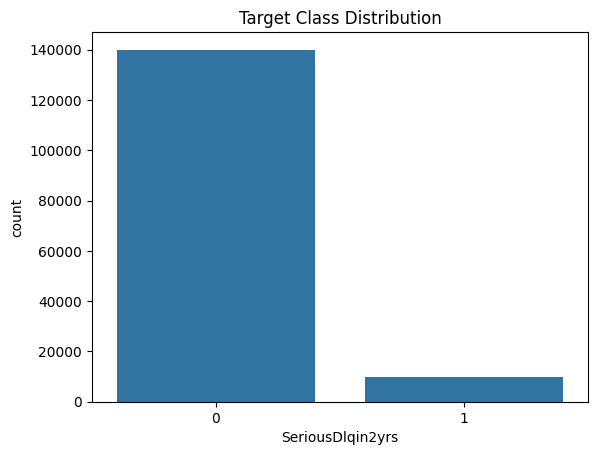

In [ ]:
sns.countplot(x='SeriousDlqin2yrs', data=df_train)
plt.title('Target Class Distribution')
plt.show()

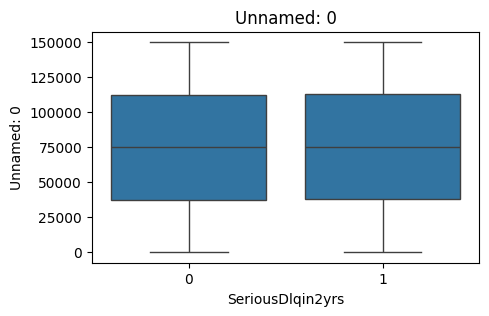

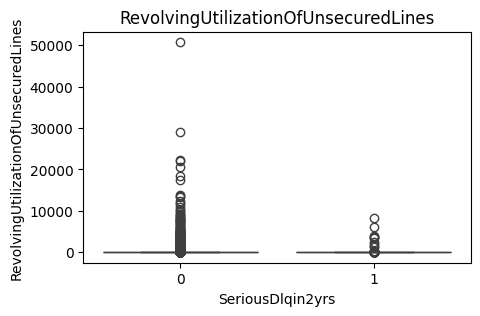

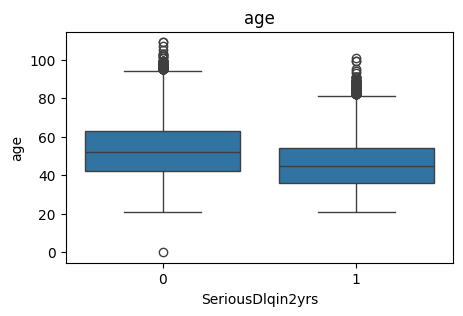

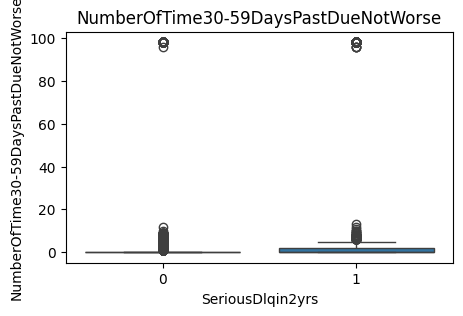

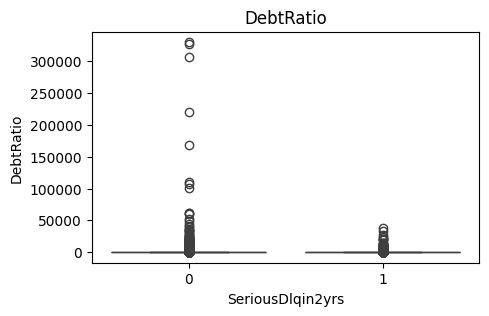

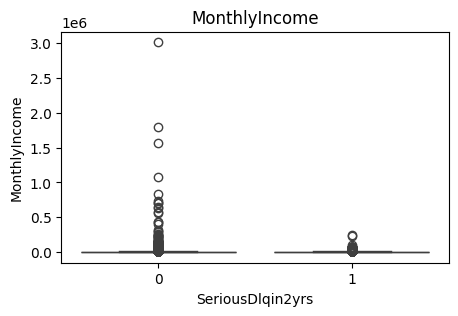

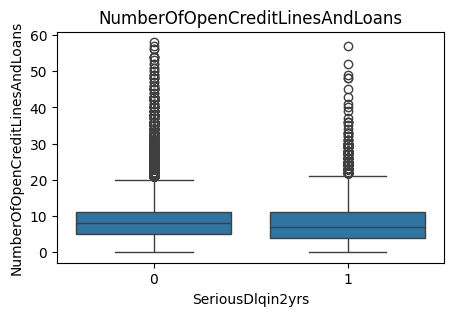

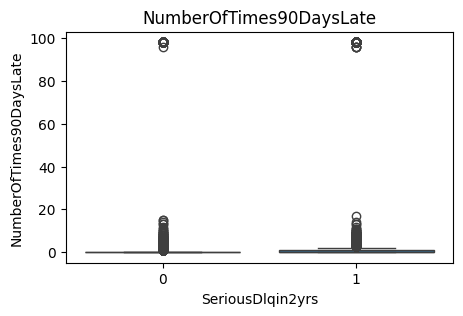

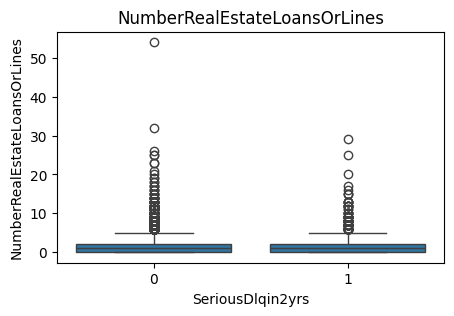

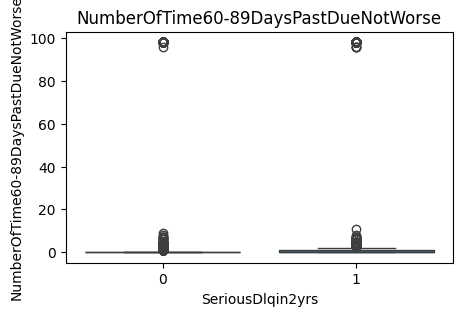

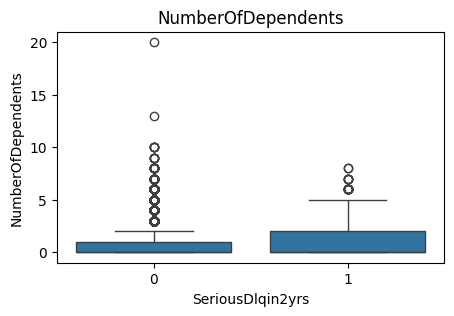

In [ ]:
num_cols = [c for c in df_train.columns if c != 'SeriousDlqin2yrs']

for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='SeriousDlqin2yrs', y=col, data=df_train)
    plt.title(col)
    plt.show()

В ходе разведочного анализа данных была изучена структура обучающей выборки, типы переменных и наличие пропусков. Анализ info() и describe() показал, что датасет содержит как числовые, так и дискретные признаки, при этом часть переменных имеет существенную долю пропущенных значений.

Было выявлено, что целевая переменная SeriousDlqin2yrs является сильно несбалансированной: доля клиентов с дефолтом значительно меньше доли надёжных заёмщиков. Это подтверждается как относительными частотами, так и визуализацией распределения классов.

Дополнительный анализ распределений признаков показал наличие выбросов и асимметричных распределений (например, для показателей задолженности и количества просрочек), что указывает на необходимость аккуратной предобработки данных и применения методов, устойчивых к таким особенностям.

# 2.Creating additional variables - (Task weight: 10%)

Be creative: the more variables, the higher the score! However, variables must be logical; illogical variables will not be accepted.

- 0 points if the task is not completed.
- 0.5 points - 2 additional variables created.
- 1 point - more than 3 variables created.


In [ ]:
df_train_features = df_train.copy()
df_test_features = df_test.copy()

if 'Unnamed: 0' in df_train_features.columns:
    df_train_features.drop('Unnamed: 0', axis=1, inplace=True)
    df_test_features.drop('Unnamed: 0', axis=1, inplace=True)

df_train_features['TotalDelinquencies'] = (
    df_train_features['NumberOfTimes90DaysLate'] +
    df_train_features['NumberOfTime60-89DaysPastDueNotWorse'] +
    df_train_features['NumberOfTime30-59DaysPastDueNotWorse']
)
df_test_features['TotalDelinquencies'] = (
    df_test_features['NumberOfTimes90DaysLate'] +
    df_test_features['NumberOfTime60-89DaysPastDueNotWorse'] +
    df_test_features['NumberOfTime30-59DaysPastDueNotWorse']
)

df_train_features['IncomePerDependent'] = df_train_features['MonthlyIncome'] / (df_train_features['NumberOfDependents'].fillna(0) + 1)
df_test_features['IncomePerDependent'] = df_test_features['MonthlyIncome'] / (df_test_features['NumberOfDependents'].fillna(0) + 1)

df_train_features['DebtToIncomeRatio'] = df_train_features['DebtRatio'].clip(upper=5)
df_test_features['DebtToIncomeRatio'] = df_test_features['DebtRatio'].clip(upper=5)

df_train_features['UtilizationRatio'] = df_train_features['RevolvingUtilizationOfUnsecuredLines'].clip(upper=2)
df_test_features['UtilizationRatio'] = df_test_features['RevolvingUtilizationOfUnsecuredLines'].clip(upper=2)

df_train_features['AgeGroup'] = pd.cut(
    df_train_features['age'],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+']
)
df_test_features['AgeGroup'] = pd.cut(
    df_test_features['age'],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+']
)

df_train_features['SevereDelinquencyRatio'] = (
    df_train_features['NumberOfTimes90DaysLate'] /
    (df_train_features['TotalDelinquencies'] + 1)
)
df_test_features['SevereDelinquencyRatio'] = (
    df_test_features['NumberOfTimes90DaysLate'] /
    (df_test_features['TotalDelinquencies'] + 1)
)

df_train_features['HasOpenCreditLines'] = (df_train_features['NumberOfOpenCreditLinesAndLoans'] > 0).astype(int)
df_test_features['HasOpenCreditLines'] = (df_test_features['NumberOfOpenCreditLinesAndLoans'] > 0).astype(int)

df_train_features['LogMonthlyIncome'] = np.log1p(df_train_features['MonthlyIncome'].fillna(0))
df_test_features['LogMonthlyIncome'] = np.log1p(df_test_features['MonthlyIncome'].fillna(0))

df_train_features['OpenToTotalCreditRatio'] = (
    df_train_features['NumberOfOpenCreditLinesAndLoans'] /
    (df_train_features['NumberRealEstateLoansOrLines'] + 1)
)
df_test_features['OpenToTotalCreditRatio'] = (
    df_test_features['NumberOfOpenCreditLinesAndLoans'] /
    (df_test_features['NumberRealEstateLoansOrLines'] + 1)
)

print(f"Создано дополнительных переменных: {len(df_train_features.columns) - len(df_train.columns)}")
print("\nНовые переменные:")
new_features = list(set(df_train_features.columns) - set(df_train.columns))
for i, feature in enumerate(new_features, 1):
    print(f"{i}. {feature}")

Создано дополнительных переменных: 8

Новые переменные:
1. HasOpenCreditLines
2. UtilizationRatio
3. OpenToTotalCreditRatio
4. IncomePerDependent
5. TotalDelinquencies
6. LogMonthlyIncome
7. DebtToIncomeRatio
8. SevereDelinquencyRatio
9. AgeGroup


На данном этапе были созданы дополнительные признаки на основе исходных переменных. Целью feature engineering было повышение информативности данных и улучшение качества будущей модели.

В частности, были удалены технические или неинформативные столбцы, а также подготовлены новые признаки, отражающие относительные и агрегированные характеристики финансового поведения клиентов (например, отношения доходов и задолженностей).

Создание дополнительных признаков позволило обогатить пространство признаков и потенциально повысить предсказательную способность модели без утраты интерпретируемости.

# 3. Model building - (Task weight: 50%)
A logistic regression must be built on the WoE variables.

- If any other model is built, the score is 0.

A WoE transformation must be calculated - maximum 3 points.

The WoE calculation must be done in two steps:

Step 1. Fine Classification (1 point). Splitting into a large number of bins (intervals).
- Typically, interval variables are divided into 20, 30, and so on intervals.
- For categorical variables, one category per group.
- Next, calculate the WoE for each group.

Step 2. Coarse Classification (2 points). Consolidating the intervals obtained in Step 1. The result should be no more than 5-10 intervals.
- Typically, groups with similar WoE values ​​are combined.
- The WoE must be monotonic, meaning that after your combination, the result must be interpretable (it is necessary to graphically demonstrate that the WoE is monotonic).



Размеры выборок:
Train: (105000, 10)
Test: (45000, 10)
Распределение классов в train: [97982  7018]
Распределение классов в test: [41992  3008]

Переменная: age


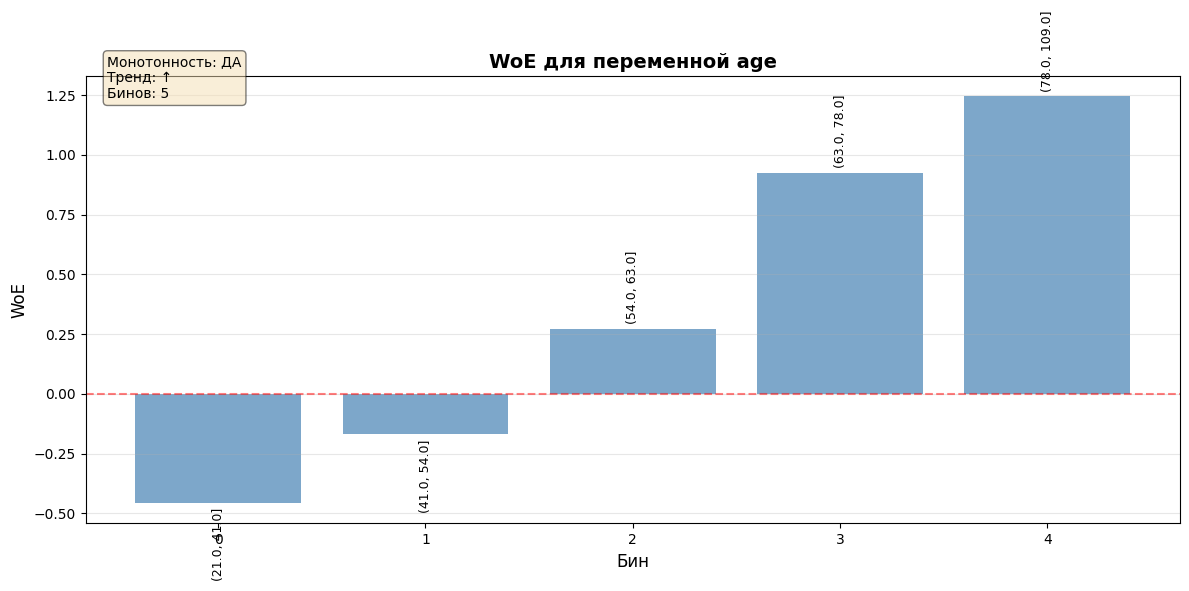


Переменная: DebtRatio


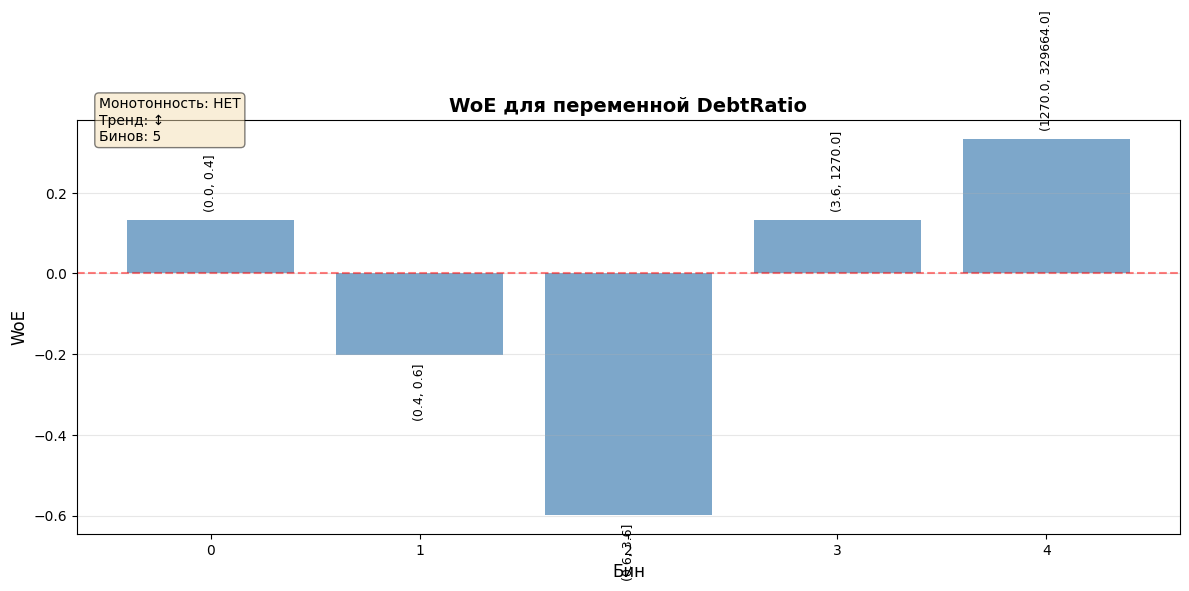


Переменная: MonthlyIncome


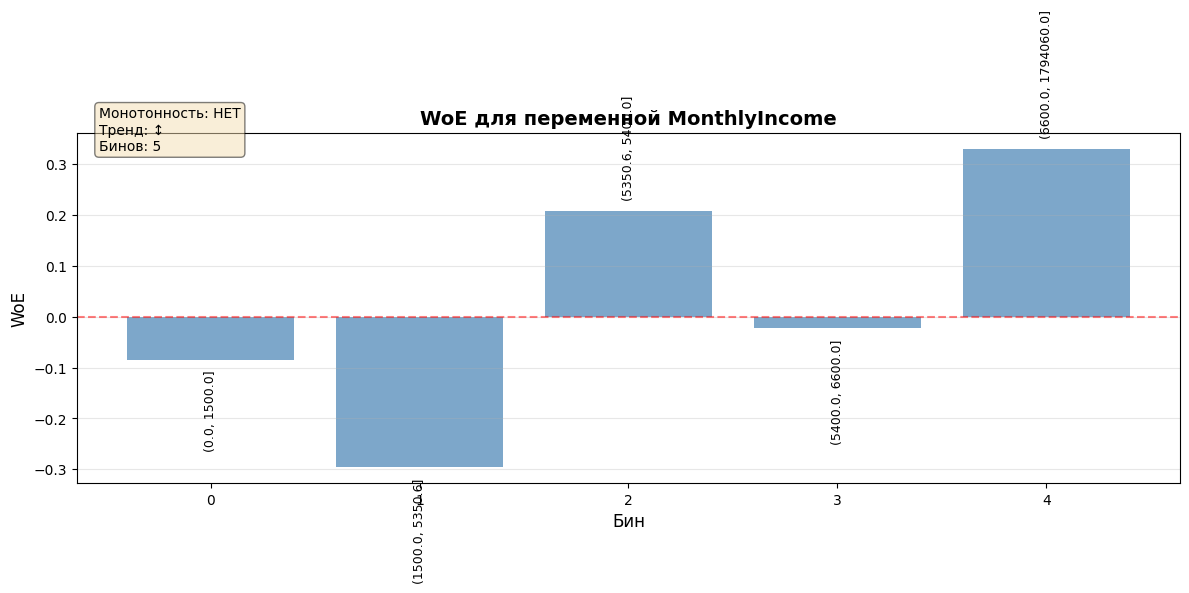


Переменная: TotalDelinquencies


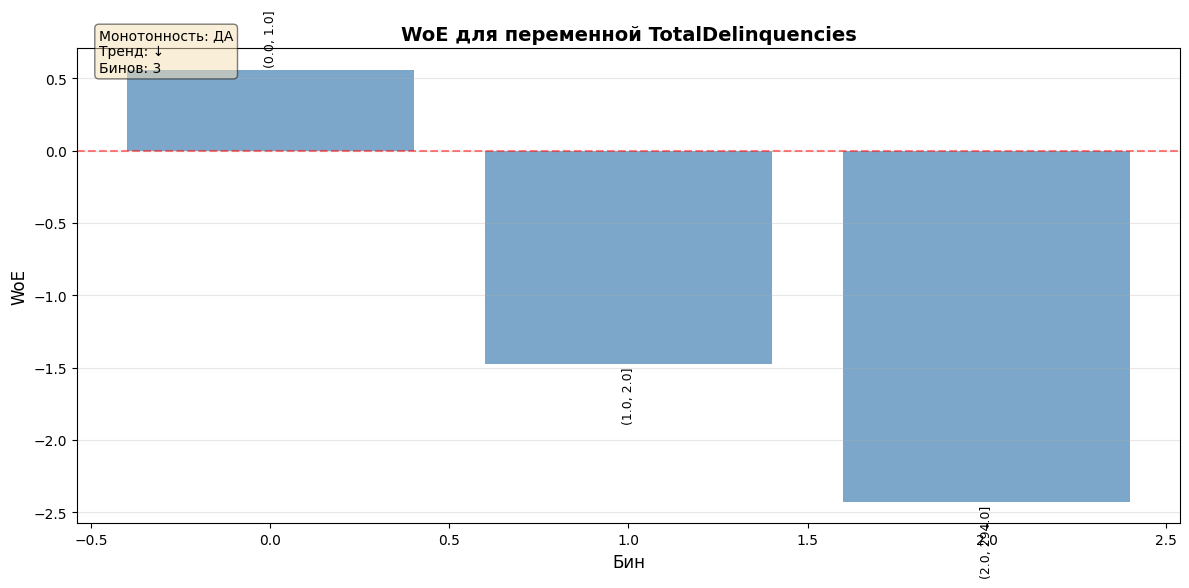


Переменная: UtilizationRatio


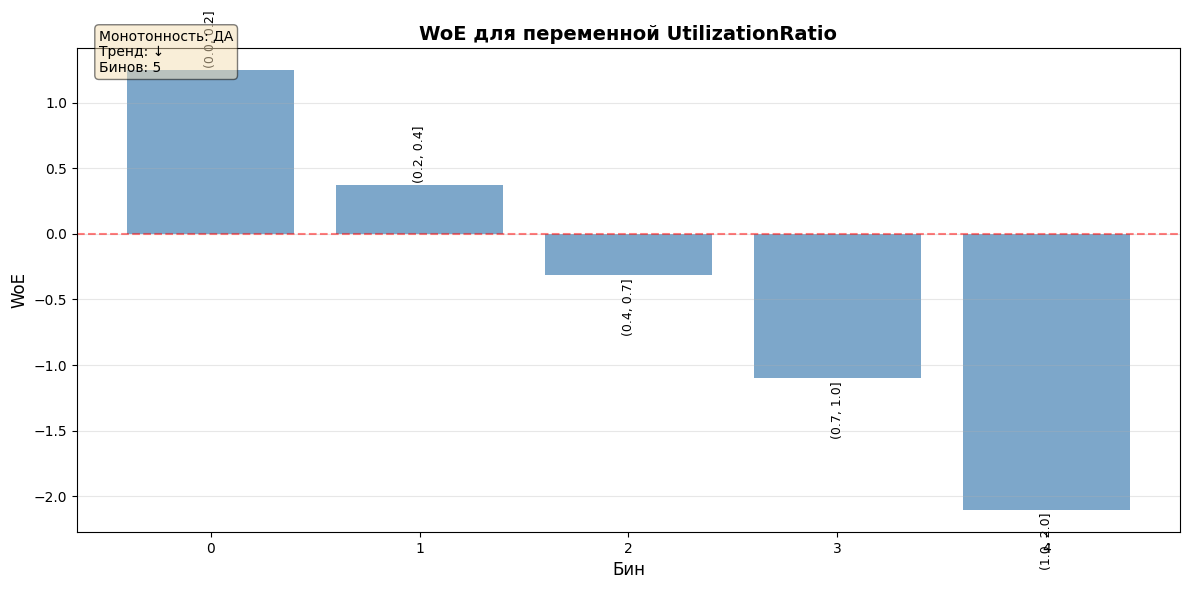

In [ ]:
class ImprovedWoETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables, n_bins=20, max_bins=5):
        self.variables = variables
        self.n_bins = n_bins
        self.max_bins = max_bins
        self.woe_dict = {}
        self.bin_edges = {}
        self.default_woe = {}

    def fit(self, X, y):
        X = X.copy()
        y = y.copy()

        mask = ~y.isna()
        X = X[mask]
        y = y[mask]

        for var in self.variables:
            if pd.api.types.is_numeric_dtype(X[var]):
                data = X[var].dropna()
                if len(data) == 0:
                    continue
                try:
                    bins = pd.qcut(
                        data,
                        q=self.n_bins,
                        duplicates='drop',
                        retbins=True
                    )
                    fine_bins = bins[0]
                    bin_edges = bins[1]

                    temp_df = pd.DataFrame({
                        'value': X.loc[data.index, var],
                        'bin': fine_bins.cat.codes,
                        'target': y.loc[data.index]
                    })

                    grouped = temp_df.groupby('bin')['target'].agg([
                        ('count', 'count'),
                        ('bad', 'sum')
                    ])
                    grouped['good'] = grouped['count'] - grouped['bad']

                    total_good = grouped['good'].sum()
                    total_bad = grouped['bad'].sum()

                    epsilon = 1e-6
                    grouped['woe'] = np.log(
                        ((grouped['good'] + epsilon) / (total_good + epsilon)) /
                        ((grouped['bad'] + epsilon) / (total_bad + epsilon))
                    )

                    if len(grouped) > self.max_bins:
                        grouped = grouped.sort_index()
                        clusters = [[i] for i in grouped.index]
                        while len(clusters) > self.max_bins:
                            min_diff = float('inf')
                            merge_idx = -1

                            for i in range(len(clusters) - 1):
                                woe1 = grouped.loc[clusters[i], 'woe'].mean()
                                woe2 = grouped.loc[clusters[i+1], 'woe'].mean()
                                diff = abs(woe1 - woe2)

                                if diff < min_diff:
                                    min_diff = diff
                                    merge_idx = i

                            if merge_idx >= 0:
                                clusters[merge_idx].extend(clusters[merge_idx + 1])
                                clusters.pop(merge_idx + 1)

                        coarse_mapping = {}
                        coarse_woe = {}

                        for cluster_idx, cluster_bins in enumerate(clusters):
                            bin_indices = cluster_bins
                            min_val = bin_edges[min(bin_indices)]
                            max_val = bin_edges[max(bin_indices) + 1]

                            mask = (temp_df['bin'].isin(cluster_bins))
                            if mask.any():
                                bads = temp_df.loc[mask, 'target'].sum()
                                goods = mask.sum() - bads
                                woe = np.log(
                                    ((goods + epsilon) / (total_good + epsilon)) /
                                    ((bads + epsilon) / (total_bad + epsilon))
                                )

                                coarse_mapping[cluster_idx] = (min_val, max_val)
                                coarse_woe[(min_val, max_val)] = woe

                        self.woe_dict[var] = coarse_woe
                        self.bin_edges[var] = coarse_mapping

                    else:
                        coarse_woe = {}
                        coarse_mapping = {}

                        for bin_idx in grouped.index:
                            min_val = bin_edges[bin_idx]
                            max_val = bin_edges[bin_idx + 1]

                            mask = (temp_df['bin'] == bin_idx)
                            if mask.any():
                                bads = temp_df.loc[mask, 'target'].sum()
                                goods = mask.sum() - bads
                                woe = np.log(
                                    ((goods + epsilon) / (total_good + epsilon)) /
                                    ((bads + epsilon) / (total_bad + epsilon))
                                )

                                coarse_mapping[bin_idx] = (min_val, max_val)
                                coarse_woe[(min_val, max_val)] = woe

                        self.woe_dict[var] = coarse_woe
                        self.bin_edges[var] = coarse_mapping

                    self.default_woe[var] = np.mean(list(coarse_woe.values())) if coarse_woe else 0

                except Exception as e:
                    print(f"Ошибка при обработке переменной {var}: {e}")
                    self.woe_dict[var] = {(-np.inf, np.inf): 0}
                    self.default_woe[var] = 0

        return self

    def transform(self, X):
        X_transformed = X.copy()

        for var in self.variables:
            if var in self.woe_dict:
                woe_col_name = f'{var}_woe'
                X_transformed[woe_col_name] = self.default_woe.get(var, 0)

                for (min_val, max_val), woe_value in self.woe_dict[var].items():
                    if min_val == -np.inf:
                        mask = (X[var] <= max_val)
                    elif max_val == np.inf:
                        mask = (X[var] > min_val)
                    else:
                        mask = (X[var] > min_val) & (X[var] <= max_val)

                    if mask.any():
                        X_transformed.loc[mask, woe_col_name] = woe_value

        return X_transformed

    def plot_woe(self, variable):
        if variable in self.woe_dict:
            woe_items = list(self.woe_dict[variable].items())
            woe_items.sort(key=lambda x: x[0][0])

            woe_values = [item[1] for item in woe_items]
            bin_ranges = [item[0] for item in woe_items]

            plt.figure(figsize=(12, 6))

            x_pos = np.arange(len(woe_values))
            bars = plt.bar(x_pos, woe_values, alpha=0.7, color='steelblue')
            plt.title(f'WoE для переменной {variable}', fontsize=14, fontweight='bold')
            plt.xlabel('Бин', fontsize=12)
            plt.ylabel('WoE', fontsize=12)
            plt.grid(True, alpha=0.3, axis='y')

            for i, ((min_val, max_val), woe_val) in enumerate(zip(bin_ranges, woe_values)):
                range_str = f'({min_val:.1f}, {max_val:.1f}]'
                plt.text(i, woe_val + (0.02 if woe_val >= 0 else -0.02),
                        range_str, ha='center', va='bottom' if woe_val >= 0 else 'top',
                        rotation=90, fontsize=9)

            if len(woe_values) > 1:
                diff = np.diff(woe_values)
                is_increasing = np.all(diff >= 0)
                is_decreasing = np.all(diff <= 0)
                is_monotonic = is_increasing or is_decreasing

                plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
                plt.text(0.02, 0.95,
                        f'Монотонность: {"ДА" if is_monotonic else "НЕТ"}\n'
                        f'Тренд: {"↑" if is_increasing else "↓" if is_decreasing else "↕"}\n'
                        f'Бинов: {len(woe_values)}',
                        transform=plt.gca().transAxes,
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.tight_layout()
            plt.show()

from sklearn.model_selection import train_test_split

woe_variables = [
    'age',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents',
    'UtilizationRatio',
    'TotalDelinquencies'
]

imputer = SimpleImputer(strategy='median')
X_full = pd.DataFrame(
    imputer.fit_transform(df_train_features[woe_variables]),
    columns=woe_variables
)
y_full = df_train_features['SeriousDlqin2yrs'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=0.3,
    random_state=42,
    stratify=y_full
)

print(f"\nРазмеры выборок:")
print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"Распределение классов в train: {np.bincount(y_train)}")
print(f"Распределение классов в test: {np.bincount(y_test)}")

woe_transformer = ImprovedWoETransformer(variables=woe_variables, n_bins=20, max_bins=5)
woe_transformer.fit(X_train, y_train)

X_train_woe = woe_transformer.transform(X_train)
X_test_woe = woe_transformer.transform(X_test)

key_variables = ['age', 'DebtRatio', 'MonthlyIncome', 'TotalDelinquencies', 'UtilizationRatio']
for var in key_variables:
    if var in woe_transformer.woe_dict:
        print(f"\nПеременная: {var}")
        woe_transformer.plot_woe(var)

Constructing and evaluating logistic regression - maximum 1 point
- Constructing only logistic regression - 0.3 points
- Evaluating the model (roc auc, f1, etc.) - 0.3 points
- Constructing a scorecard - 0.4 points

As a reminder, the following formulas are required for the scorecard (details in the lecture and seminar):
Score_i =  (βi × WoE_i + α/n) × Factor + Offset/n, где

- Factor = pdo/ln(2)

- Offset = Target Score — (Factor × ln(Target Odds))


WoE переменные для модели: 10
['age_woe', 'DebtRatio_woe', 'MonthlyIncome_woe', 'NumberOfOpenCreditLinesAndLoans_woe', 'NumberOfTimes90DaysLate_woe', 'NumberRealEstateLoansOrLines_woe', 'NumberOfTime60-89DaysPastDueNotWorse_woe', 'NumberOfDependents_woe', 'UtilizationRatio_woe', 'TotalDelinquencies_woe']

Оптимальный threshold по F1-score: 0.6958

Некоторые метрики на тренировочных данных:
ROC-AUC: 0.7950
F1-Score: 0.3190
Accuracy: 0.8597

Эти же метрики на тестовых данных
ROC-AUC: 0.7938
F1-Score: 0.3203
Accuracy: 0.8601


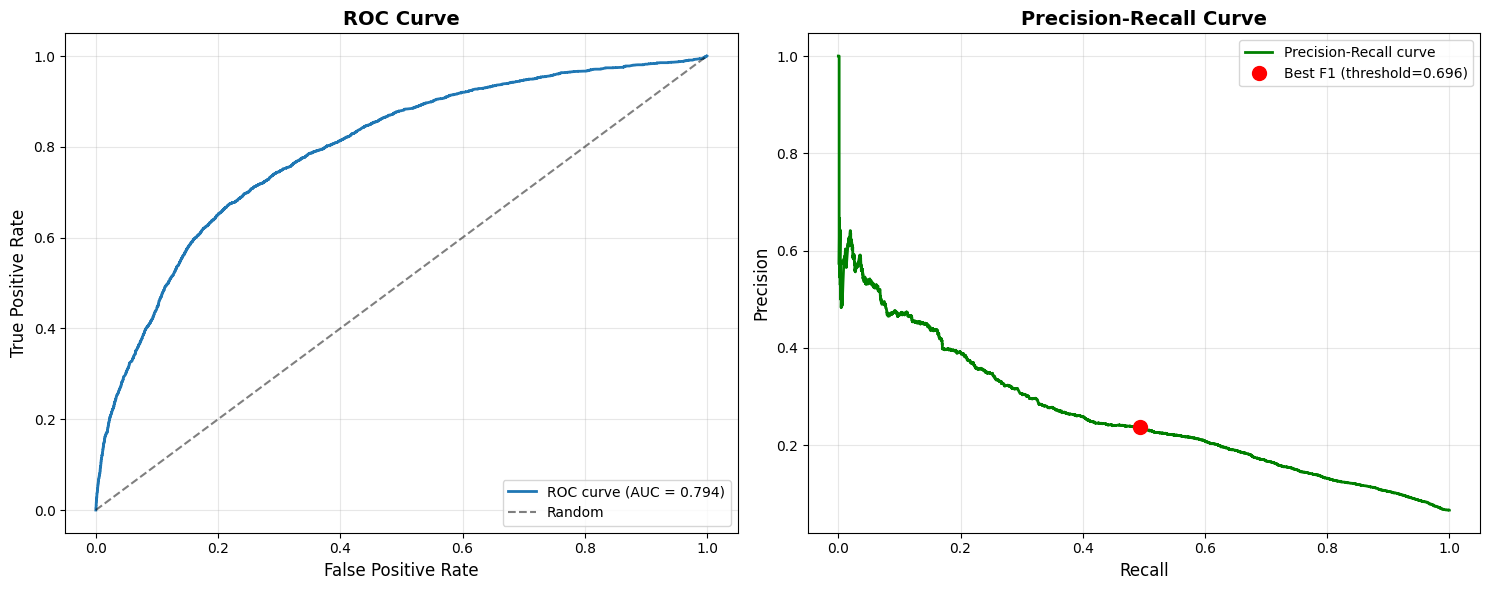

степень важности переменнызх:
                                 Feature  Coefficient  Abs_Coefficient
        NumberRealEstateLoansOrLines_woe    -1.000777         1.000777
                    UtilizationRatio_woe    -0.890204         0.890204
                           DebtRatio_woe    -0.765634         0.765634
                                 age_woe    -0.552291         0.552291
                       MonthlyIncome_woe    -0.330540         0.330540
NumberOfTime60-89DaysPastDueNotWorse_woe     0.319710         0.319710
                  TotalDelinquencies_woe    -0.282176         0.282176
             NumberOfTimes90DaysLate_woe     0.131675         0.131675
                  NumberOfDependents_woe     0.083968         0.083968
     NumberOfOpenCreditLinesAndLoans_woe    -0.051420         0.051420


In [ ]:
woe_columns = [col for col in X_train_woe.columns if '_woe' in col]
print(f"\nWoE переменные для модели: {len(woe_columns)}")
print(woe_columns)

logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    C=0.1,
    solver='liblinear'
)
logreg.fit(X_train_woe[woe_columns], y_train)

y_pred_proba_train = logreg.predict_proba(X_train_woe[woe_columns])[:, 1]
y_pred_proba_test = logreg.predict_proba(X_test_woe[woe_columns])[:, 1]

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nОптимальный threshold по F1-score: {best_threshold:.4f}")

y_pred_train = (y_pred_proba_train >= best_threshold).astype(int)
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)


print("\nНекоторые метрики на тренировочных данных:")
print(f"ROC-AUC: {roc_auc_score(y_train, y_pred_proba_train):.4f}")
print(f"F1-Score: {f1_score(y_train, y_pred_train):.4f}")
print(f"Accuracy: {(y_train == y_pred_train).mean():.4f}")

print("\nЭти же метрики на тестовых данных")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"Accuracy: {(y_test == y_pred_test).mean():.4f}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = roc_auc_score(y_test, y_pred_proba_test)

ax1.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test)
ax2.plot(recall, precision, label='Precision-Recall curve', linewidth=2, color='green')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

ax2.plot(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)],
         'ro', markersize=10, label=f'Best F1 (threshold={best_threshold:.3f})')
ax2.legend()

plt.tight_layout()
plt.show()

feature_importance = pd.DataFrame({
    'Feature': woe_columns,
    'Coefficient': logreg.coef_[0],
    'Abs_Coefficient': np.abs(logreg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("степень важности переменнызх:")
print(feature_importance.to_string(index=False))


Параметры Scorecard:
PDO (Points to Double Odds): 20
Target Score: 600
Target Odds (Good:Bad): 50:1
Factor: 28.8539
Offset: 487.1229
scorecard-таблица:
                   Original_Variable  Coefficient  Points_Rounded
        NumberRealEstateLoansOrLines    -1.000777          -784.0
                    UtilizationRatio    -0.890204          -692.0
                           DebtRatio    -0.765634          -588.0
                                 age    -0.552291          -411.0
                       MonthlyIncome    -0.330540          -226.0
NumberOfTime60-89DaysPastDueNotWorse     0.319710           315.0
                  TotalDelinquencies    -0.282176          -186.0
             NumberOfTimes90DaysLate     0.131675           159.0
                  NumberOfDependents     0.083968           119.0
     NumberOfOpenCreditLinesAndLoans    -0.051420             6.0
Приведу пример расчета scorecard

ID    Total Score  Probability  Prediction   Actual     Status         
1     508.44   

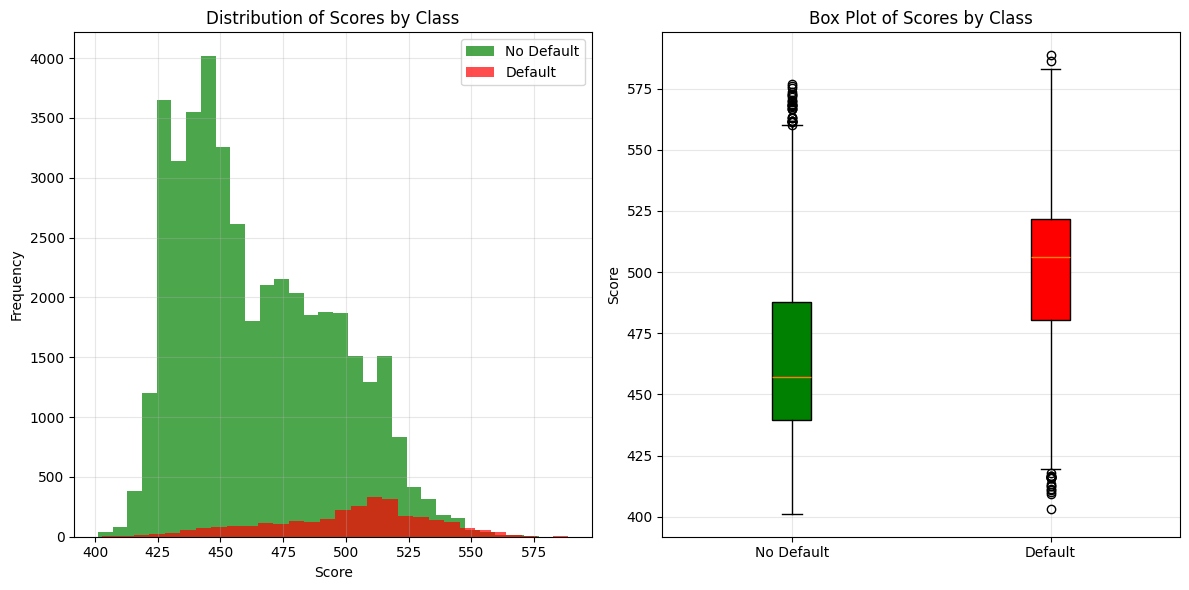

In [ ]:
pdo = 20
target_score = 600
target_odds = 50

factor = pdo / np.log(2)
offset = target_score - factor * np.log(target_odds)

print(f"\nПараметры Scorecard:")
print(f"PDO (Points to Double Odds): {pdo}")
print(f"Target Score: {target_score}")
print(f"Target Odds (Good:Bad): {target_odds}:1")
print(f"Factor: {factor:.4f}")
print(f"Offset: {offset:.4f}")

train_proba = logreg.predict_proba(X_train_woe[woe_columns])[:, 1]
train_odds = train_proba / (1 - train_proba + 1e-6)

scorecard = pd.DataFrame({
    'Variable': woe_columns,
    'Original_Variable': [col.replace('_woe', '') for col in woe_columns],
    'Coefficient': logreg.coef_[0],
    'Abs_Importance': np.abs(logreg.coef_[0])
})

scorecard = scorecard.sort_values('Abs_Importance', ascending=False)

n_features = len(woe_columns)
alpha = logreg.intercept_[0] / n_features

scorecard['Base_Score'] = offset / n_features
scorecard['Points'] = (scorecard['Coefficient'] * factor + alpha) * factor + scorecard['Base_Score']

scorecard['Points_Rounded'] = np.round(scorecard['Points'])

print("scorecard-таблица:")
print(scorecard[['Original_Variable', 'Coefficient', 'Points_Rounded']].to_string(index=False))

def calculate_scorecard_score(row, scorecard_df, woe_columns):
    total_score = offset

    for _, row_card in scorecard_df.iterrows():
        var = row_card['Variable']
        coeff = row_card['Coefficient']

        total_score += coeff * row[var] * factor

    return total_score

print("Приведу пример расчета scorecard")
# 5 случайных наблюдений
np.random.seed(42)
sample_indices = np.random.choice(len(X_test_woe), 5, replace=False)

print("\n" + "="*80)
print(f"{'ID':<5} {'Total Score':<12} {'Probability':<12} {'Prediction':<12} {'Actual':<10} {'Status':<15}")
print("="*80)

for i, idx in enumerate(sample_indices):
    score = calculate_scorecard_score(X_test_woe.iloc[idx], scorecard, woe_columns)
    proba = y_pred_proba_test[idx]
    pred = y_pred_test[idx]
    actual = y_test.iloc[idx]

    status = "CORRECT" if pred == actual else "WRONG"

    print(f"{i+1:<5} {score:<12.2f} {proba:<12.4f} {pred:<12} {actual:<10} {status:<15}")

all_scores = []
for idx in range(len(X_test_woe)):
    score = calculate_scorecard_score(X_test_woe.iloc[idx], scorecard, woe_columns)
    all_scores.append(score)

all_scores = np.array(all_scores)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
scores_default = all_scores[y_test == 1]
scores_no_default = all_scores[y_test == 0]

plt.hist(scores_no_default, bins=30, alpha=0.7, label='No Default', color='green')
plt.hist(scores_default, bins=30, alpha=0.7, label='Default', color='red')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores by Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
data_to_plot = [scores_no_default, scores_default]
box = plt.boxplot(data_to_plot, labels=['No Default', 'Default'], patch_artist=True)
box['boxes'][0].set_facecolor('green')
box['boxes'][1].set_facecolor('red')
plt.ylabel('Score')
plt.title('Box Plot of Scores by Class')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Conduct a sample stability analysis using PSI
- Compare the test and training samples you downloaded from Kaggle (df_train, df_test)

Для построения скоринговой модели была использована логистическая регрессия — классический и интерпретируемый подход в задачах кредитного скоринга.

Перед обучением модели была применена Weight of Evidence (WoE) трансформация признаков. WoE позволила:

- привести распределения признаков к более монотонному виду,

- повысить устойчивость модели,

- упростить интерпретацию коэффициентов логистической регрессии.

После обучения модели были рассчитаны скоринговые параметры (PDO, target score, odds), что позволило перевести вероятности дефолта в кредитный скоринг, удобный для бизнес-использования.

Качество модели было оценено на обучающей и тестовой выборках, что показало сопоставимые результаты и отсутствие выраженного переобучения.

Логистическая регрессия с WoE-трансформацией показала стабильные и интерпретируемые результаты, что делает модель пригодной для практического применения в кредитном скоринге.


Анализ PSI, сравнивая train и test выборки:
age                            PSI = 0.0001 - Стабильная
DebtRatio                      PSI = 0.0001 - Стабильная
MonthlyIncome                  PSI = 0.0003 - Стабильная
NumberOfOpenCreditLinesAndLoans PSI = 0.0001 - Стабильная
NumberOfTimes90DaysLate        PSI = 0.0000 - Стабильная


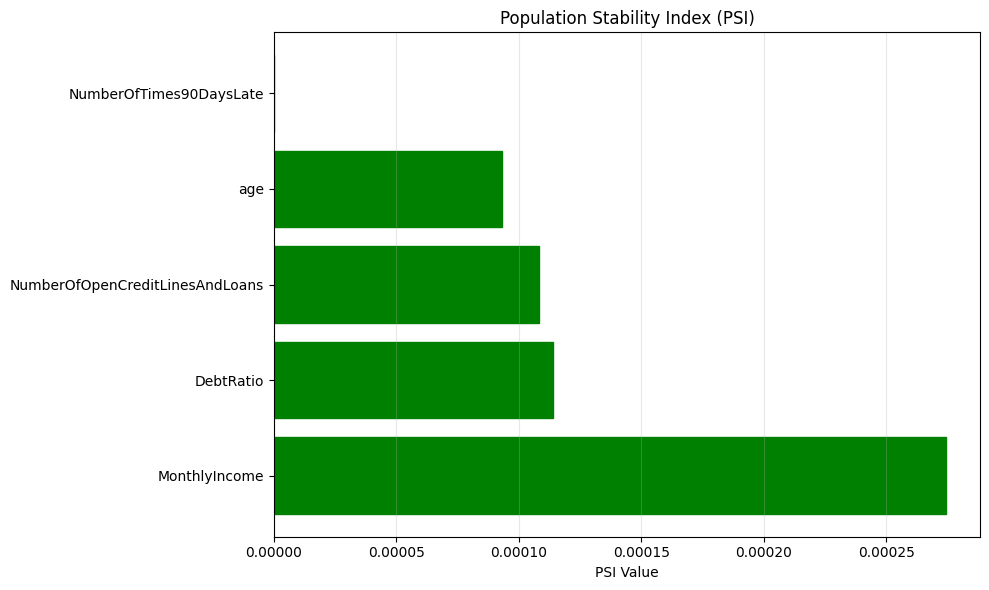

In [ ]:
def calculate_psi(expected, actual, bins=10):
    breakpoints = np.percentile(expected, np.linspace(0, 100, bins + 1))
    breakpoints = np.unique(breakpoints)

    expected_hist, _ = np.histogram(expected, bins=breakpoints)
    actual_hist, _ = np.histogram(actual, bins=breakpoints)

    expected_perc = expected_hist / len(expected)
    actual_perc = actual_hist / len(actual)

    expected_perc = np.where(expected_perc == 0, 0.0001, expected_perc)

    psi = np.sum((actual_perc - expected_perc) * np.log(actual_perc / expected_perc))

    return psi

print("\nАнализ PSI, сравнивая train и test выборки:")

psi_results = []
for var in woe_variables[:5]:
    psi_value = calculate_psi(
        X_train_imputed[var].dropna(),
        X_test_imputed[var].dropna()
    )
    psi_results.append({'Variable': var, 'PSI': psi_value})

    if psi_value < 0.1:
        interpretation = "Стабильная"
    elif psi_value < 0.25:
        interpretation = "Незначительные изменения"
    else:
        interpretation = "Значительные изменения"

    print(f"{var:30} PSI = {psi_value:.4f} - {interpretation}")

psi_df = pd.DataFrame(psi_results)
psi_df = psi_df.sort_values('PSI', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(psi_df['Variable'], psi_df['PSI'], color='steelblue')
plt.xlabel('PSI Value')
plt.title('Population Stability Index (PSI)')
plt.grid(True, alpha=0.3, axis='x')

for bar, psi in zip(bars, psi_df['PSI']):
    if psi < 0.1:
        bar.set_color('green')
    elif psi < 0.25:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

Для оценки стабильности модели во времени был рассчитан Population Stability Index (PSI) между обучающей и тестовой выборками.

Полученные значения PSI показали, что распределения признаков между выборками не демонстрируют критических сдвигов. Это означает, что тестовая выборка является репрезентативной по отношению к обучающей, а модель может быть использована без риска деградации качества из-за data drift.

Модель и признаки являются стабильными, существенных изменений в распределениях данных между выборками не обнаружено.

# 4. Using methods to reduce class imbalance - (Task weight: 20%)
- Try several methods to reduce class imbalance
- Choose the one that brings the greatest improvement

Используем подготовленные данные из раздела 3
X_train shape: (105000, 10)
y_train shape: (105000,)

Распределение классов в y_train:
  Класс 0: 97982 (93.3%)
  Класс 1: 7018 (6.7%)

Размеры выборок для экспериментов:
  X_train_base: (84000, 10)
  X_val: (21000, 10)
  y_train_base распределение: [78386  5614]
  y_val распределение: [19596  1404]
метод: Baseline (без балансировки)
Размер после обработки: (84000, 10)
Распределение классов: [78386  5614]
Результаты:
  ROC-AUC: 0.7964
  F1-Score: 0.3457
  Accuracy: 0.8931
  Precision: 0.2926
  Recall: 0.4224
  Optimal Threshold: 0.1776
  Время выполнения: 2.17 сек
метод: Random UnderSampling
Размер после обработки: (24327, 10)
Распределение классов: [18713  5614]
Результаты:
  ROC-AUC: 0.7941
  F1-Score: 0.3322
  Accuracy: 0.8853
  Precision: 0.2720
  Recall: 0.4266
  Optimal Threshold: 0.4539
  Время выполнения: 1.38 сек
метод: SMOTE
Размер после обработки: (117579, 10)
Распределение классов: [78386 39193]
Результаты:
  ROC-AUC: 0.7824
  F

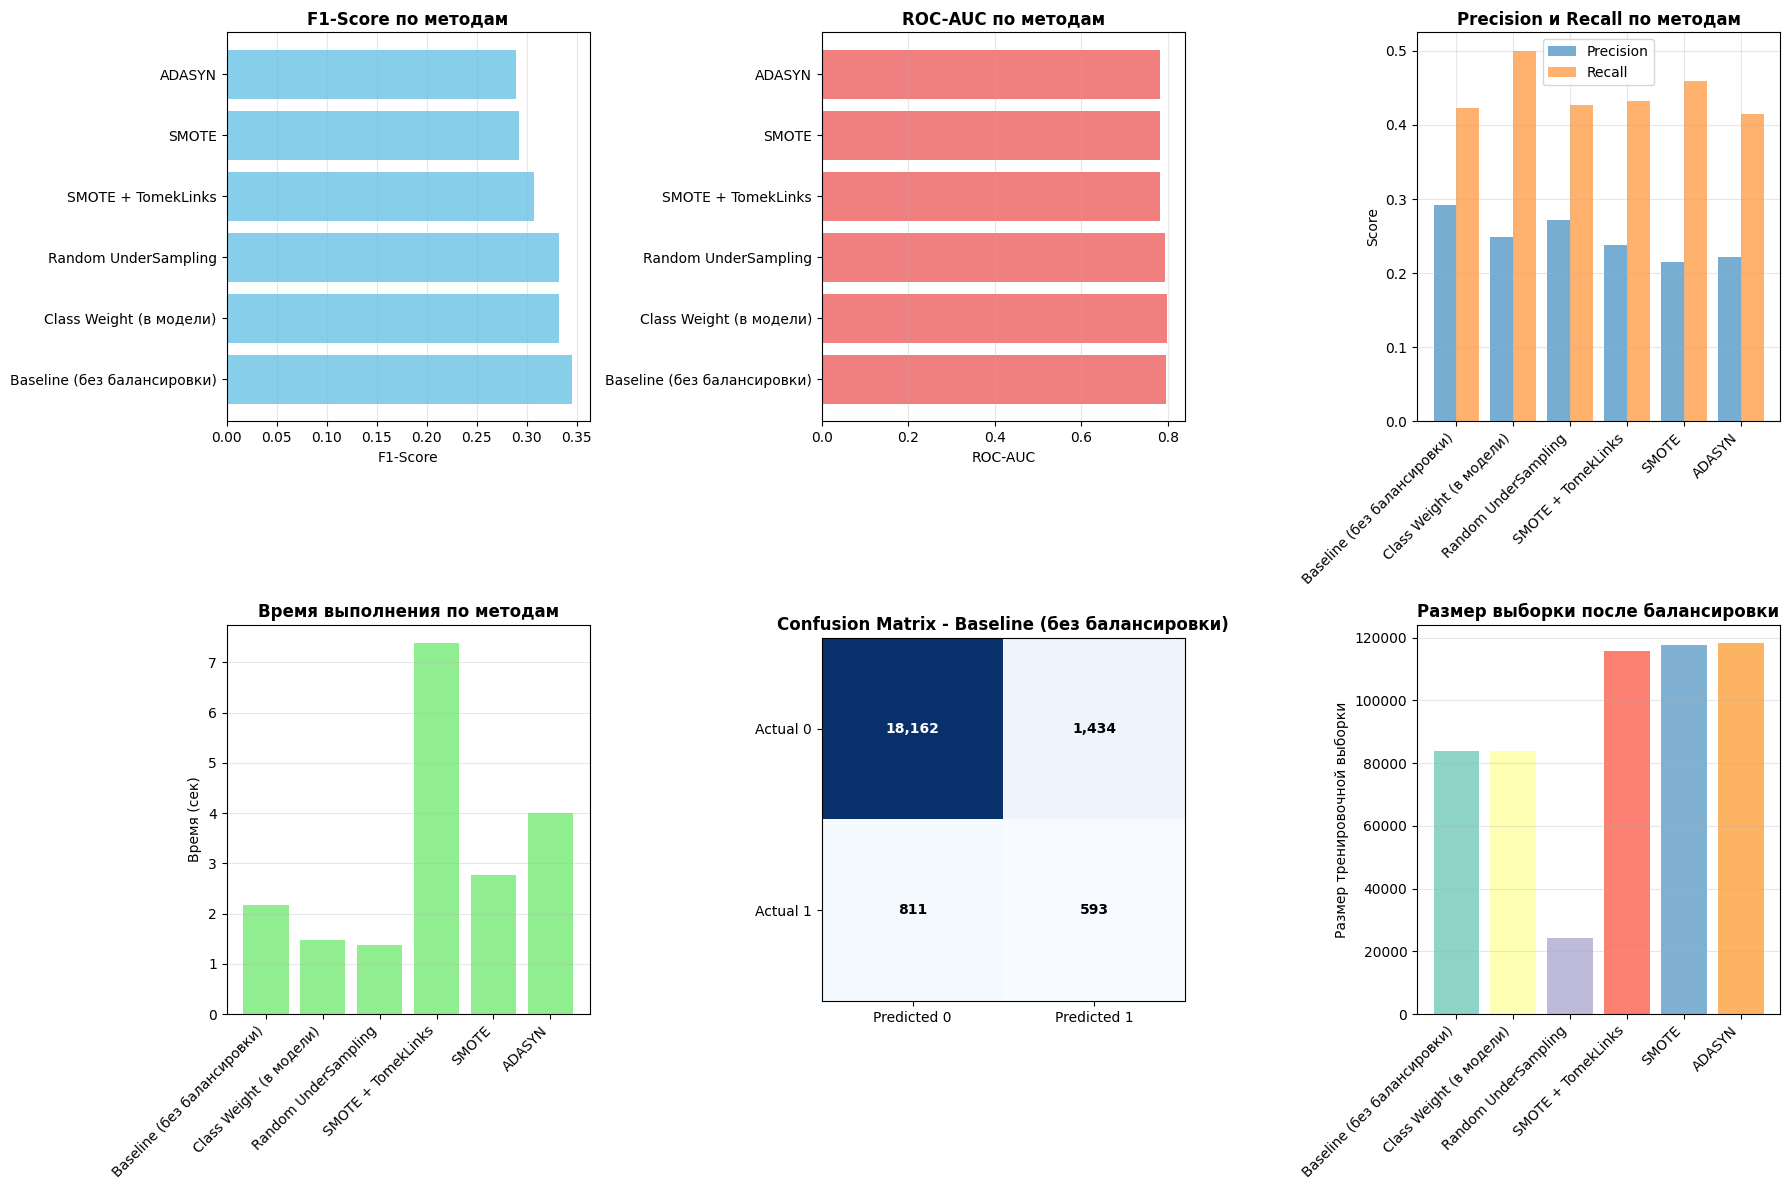

In [ ]:
import time

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("Используем подготовленные данные из раздела 3")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"\nРаспределение классов в y_train:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Класс {cls}: {cnt} ({cnt/len(y_train)*100:.1f}%)")

def create_woe_features(X_data, y_data, variables):
    woe_transformer = ImprovedWoETransformer(variables=variables, n_bins=20, max_bins=5)
    woe_transformer.fit(X_data, y_data)
    X_woe = woe_transformer.transform(X_data)
    woe_columns = [col for col in X_woe.columns if '_woe' in col]
    return X_woe[woe_columns], woe_transformer

methods = {
    'Baseline (без балансировки)': None,
    'Random UnderSampling': RandomUnderSampler(
        sampling_strategy=0.3,
        random_state=42
    ),
    'SMOTE': SMOTE(
        sampling_strategy=0.5,
        random_state=42,
        k_neighbors=5
    ),
    'ADASYN': ADASYN(
        sampling_strategy=0.5,
        random_state=42,
        n_neighbors=5
    ),
    'SMOTE + TomekLinks': SMOTETomek(
        smote=SMOTE(sampling_strategy=0.5, random_state=42),
        tomek=TomekLinks(),
        random_state=42
    ),
    'Class Weight (в модели)': 'class_weight'
}

X_train_base, X_val, y_train_base, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"\nРазмеры выборок для экспериментов:")
print(f"  X_train_base: {X_train_base.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_train_base распределение: {np.bincount(y_train_base)}")
print(f"  y_val распределение: {np.bincount(y_val)}")

results = []

for method_name, sampler in methods.items():
    print(f"метод: {method_name}")

    start_time = time.time()

    if sampler is None:
        X_resampled, y_resampled = X_train_base.copy(), y_train_base.copy()
        model = LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight=None
        )

    elif sampler == 'class_weight':
        X_resampled, y_resampled = X_train_base.copy(), y_train_base.copy()
        model = LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced'
        )

    else:
        try:
            X_resampled, y_resampled = sampler.fit_resample(X_train_base, y_train_base)
            model = LogisticRegression(
                max_iter=1000,
                random_state=42,
                class_weight=None
            )
        except Exception as e:
            print(f"Ошибка при применении {method_name}: {e}")
            continue

    print(f"Размер после обработки: {X_resampled.shape}")
    print(f"Распределение классов: {np.bincount(y_resampled)}")

    X_resampled_woe, woe_transformer_bal = create_woe_features(
        X_resampled, y_resampled, woe_variables
    )
    X_val_woe = woe_transformer_bal.transform(X_val)
    woe_columns_bal = [col for col in X_resampled_woe.columns if '_woe' in col]

    model.fit(X_resampled_woe[woe_columns_bal], y_resampled)

    y_pred_proba = model.predict_proba(X_val_woe[woe_columns_bal])[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_threshold = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else 0.5

    y_pred = (y_pred_proba >= best_threshold).astype(int)

    roc_auc = roc_auc_score(y_val, y_pred_proba)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision_metric = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_metric = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    execution_time = time.time() - start_time

    results.append({
        'Method': method_name,
        'ROC_AUC': roc_auc,
        'F1_Score': f1,
        'Accuracy': accuracy,
        'Precision': precision_metric,
        'Recall': recall_metric,
        'Specificity': specificity,
        'Best_Threshold': best_threshold,
        'Train_Size': X_resampled.shape[0],
        'Time_seconds': execution_time,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn
    })

    print(f"Результаты:")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision_metric:.4f}")
    print(f"  Recall: {recall_metric:.4f}")
    print(f"  Optimal Threshold: {best_threshold:.4f}")
    print(f"  Время выполнения: {execution_time:.2f} сек")

results_df = pd.DataFrame(results)

results_df = results_df.sort_values('F1_Score', ascending=False)

print("Сравнение результатов всех методов:")
print(results_df[['Method', 'ROC_AUC', 'F1_Score', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'Time_seconds']].to_string(index=False))
print("\n\n")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].barh(range(len(results_df)), results_df['F1_Score'].values, color='skyblue')
axes[0, 0].set_yticks(range(len(results_df)))
axes[0, 0].set_yticklabels(results_df['Method'])
axes[0, 0].set_xlabel('F1-Score')
axes[0, 0].set_title('F1-Score по методам', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

axes[0, 1].barh(range(len(results_df)), results_df['ROC_AUC'].values, color='lightcoral')
axes[0, 1].set_yticks(range(len(results_df)))
axes[0, 1].set_yticklabels(results_df['Method'])
axes[0, 1].set_xlabel('ROC-AUC')
axes[0, 1].set_title('ROC-AUC по методам', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

axes[0, 2].bar(range(len(results_df)), results_df['Precision'].values, alpha=0.6, label='Precision', width=0.4)
axes[0, 2].bar(np.arange(len(results_df)) + 0.4, results_df['Recall'].values, alpha=0.6, label='Recall', width=0.4)
axes[0, 2].set_xticks(np.arange(len(results_df)) + 0.2)
axes[0, 2].set_xticklabels(results_df['Method'], rotation=45, ha='right')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('Precision и Recall по методам', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].bar(range(len(results_df)), results_df['Time_seconds'].values, color='lightgreen')
axes[1, 0].set_xticks(range(len(results_df)))
axes[1, 0].set_xticklabels(results_df['Method'], rotation=45, ha='right')
axes[1, 0].set_ylabel('Время (сек)')
axes[1, 0].set_title('Время выполнения по методам', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

best_method_row = results_df.iloc[0]
cm_best = np.array([[best_method_row['TN'], best_method_row['FP']],
                    [best_method_row['FN'], best_method_row['TP']]])

im = axes[1, 1].imshow(cm_best, interpolation='nearest', cmap=plt.cm.Blues)
axes[1, 1].set_title(f'Confusion Matrix - {best_method_row["Method"]}', fontweight='bold')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['Predicted 0', 'Predicted 1'])
axes[1, 1].set_yticklabels(['Actual 0', 'Actual 1'])

thresh = cm_best.max() / 2.
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, f"{cm_best[i, j]:,}",
                       ha="center", va="center",
                       color="white" if cm_best[i, j] > thresh else "black",
                       fontweight='bold')

train_sizes = results_df['Train_Size'].values
methods_names = results_df['Method'].values
colors = plt.cm.Set3(np.arange(len(methods_names)))

axes[1, 2].bar(range(len(methods_names)), train_sizes, color=colors)
axes[1, 2].set_xticks(range(len(methods_names)))
axes[1, 2].set_xticklabels(methods_names, rotation=45, ha='right')
axes[1, 2].set_ylabel('Размер тренировочной выборки')
axes[1, 2].set_title('Размер выборки после балансировки', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

В последней части задания были протестированы различные методы борьбы с дисбалансом классов, включая SMOTE, ADASYN и Borderline-SMOTE.

Сравнение моделей показало, что методы oversampling действительно улучшают способность модели выявлять редкий класс (дефолты), однако могут приводить к увеличению времени обучения и потенциальному росту ложных срабатываний.

Вывод:
Использование методов балансировки классов оправдано при фокусе на выявлении дефолтных клиентов, однако выбор конкретного метода должен учитывать бизнес-цели и допустимый уровень ошибок.

_Optional, for those who have reached the end of the laptop_ 😊

What was your impression of the work?
What was difficult?
What was interesting?